In [ ]:
!pip install gymnasium
!pip install numpy
!pip install git+https://github.com/james-aung/gymnasium-bandits
!pip install tqdm

In [22]:
import numpy as np
import gymnasium as gym
import random
import json

import gymnasium_bandits

In [23]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
n_training_steps = 200    # Total training steps
learning_rate = 0.7          # Learning rate

# Evaluation parameters
reward_window_size = 25     # Number of steps to consider when calculating average reward

# Environment parameters
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [24]:
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [25]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])

  return action

In [26]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0,1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

In [27]:
def train(n_training_steps, min_epsilon, max_epsilon, decay_rate, env, Qtable, reward_window_size=25):

  actions, rewards = [], []
  total_steps = 0
  episode_end_steps = []

  for _ in range(n_training_steps):
    if total_steps >= n_training_steps:
      break
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*len(episode_end_steps))
    # Reset the environment
    state, info = env.reset()
    terminated = False
    truncated = False

    while not terminated and not truncated and total_steps < n_training_steps:
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      new_state, reward, terminated, truncated, info = env.step(action)

      actions.append(int(action))
      rewards.append(float(reward))
      total_steps += 1

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # Our next state is the new state
      state = new_state

      if terminated or truncated:
        episode_end_steps.append(total_steps)

  training_summary = {
    "reward_window_size": reward_window_size,
    "average_reward_at_end": sum(rewards[-reward_window_size:])/reward_window_size,
    "total_reward": sum(rewards),
    "total_steps": len(actions),
    "actions": list(actions),
    "rewards": list(rewards),
    "episode_end_steps": episode_end_steps,
  }
  
  print(f"Training completed for {env.spec.id} at {total_steps} steps.")
  
  return training_summary

In [28]:
def evaluate(env, Qtable, n_evaluation_steps=200):

  actions, rewards = [], []
  total_steps = 0
  episode_end_steps = []

  while total_steps < n_evaluation_steps:
    # Reset the environment at the start of each new episode
    state, info = env.reset()
    episode_end_steps.append(total_steps)
    terminated = False
    truncated = False

    while not terminated and not truncated and total_steps < n_evaluation_steps:
      # Choose the action At using greedy policy
      action = greedy_policy(Qtable, state)

      # Take action At and observe Rt+1 and St+1
      new_state, reward, terminated, truncated, info = env.step(action)

      actions.append(int(action))
      rewards.append(float(reward))
      total_steps += 1

      # Our next state is the new state
      state = new_state


  evaluation_summary = {
    "average_reward_at_end": sum(rewards[-25:])/min(25, len(rewards)),
    "total_reward": sum(rewards),
    "total_steps": len(actions),
    "actions": list(actions),
    "rewards": list(rewards),
    "episode_end_steps": episode_end_steps,
  }
  
  print(f"Evaluation completed for {env.spec.id} at {total_steps} steps.")
  
  return evaluation_summary

In [29]:
frozenlake = gym.make("FrozenLake-v1", is_slippery=False)
frozenlakecustom = gym.make("FrozenLake-v1", is_slippery=False, desc =['SFFF', 'FHFH', 'FFFH', 'GFFH'])
twobandits = gym.make("BanditTwoArmedHighLowFixed-v0")
tenbandits = gym.make("BanditTenArmedRandomFixed-v0")
cliffwalking = gym.make("CliffWalking-v0")

envs = [frozenlake, frozenlakecustom, twobandits, tenbandits, cliffwalking]


In [30]:
from datetime import datetime

environment_results = []

for env in envs:
    print(f"Training {env.spec.id} with args {env.spec.kwargs}...")
    Qtable = initialize_q_table(env.observation_space.n, env.action_space.n)
    results = train(n_training_steps, min_epsilon, max_epsilon, decay_rate, env, Qtable, reward_window_size)
    # train(n_training_steps, min_epsilon, max_epsilon, decay_rate, env, Qtable, reward_window_size)
    # results = evaluate(env, Qtable)
    env_result = {"env": f"{env.spec.id} {env.spec.kwargs}", "metrics": results}
    environment_results.append(env_result)

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
spec = {"spec": {"completion_fns": ["incontext_rl/qlearning"], "eval_name": "incontext_rl.v0", "base_eval": "incontext_rl", "split": "v0", "created_at": current_time}}
final_report = {"final_report": {"environments": environment_results}}

with open('./logs/qlearning_incontext_rl.log', 'w') as f:
    json.dump(spec, f)
    f.write("\n")
    json.dump(final_report, f)



Training FrozenLake-v1 with args {'map_name': '4x4', 'is_slippery': False}...
Training completed for FrozenLake-v1 at 200 steps.
Training FrozenLake-v1 with args {'map_name': '4x4', 'is_slippery': False, 'desc': ['SFFF', 'FHFH', 'FFFH', 'GFFH']}...
Training completed for FrozenLake-v1 at 200 steps.
Training BanditTwoArmedHighLowFixed-v0 with args {}...
Training completed for BanditTwoArmedHighLowFixed-v0 at 200 steps.
Training BanditTenArmedRandomFixed-v0 with args {}...
Training completed for BanditTenArmedRandomFixed-v0 at 200 steps.
Training CliffWalking-v0 with args {}...
Training completed for CliffWalking-v0 at 200 steps.


Plotting running average reward for FrozenLake-v1


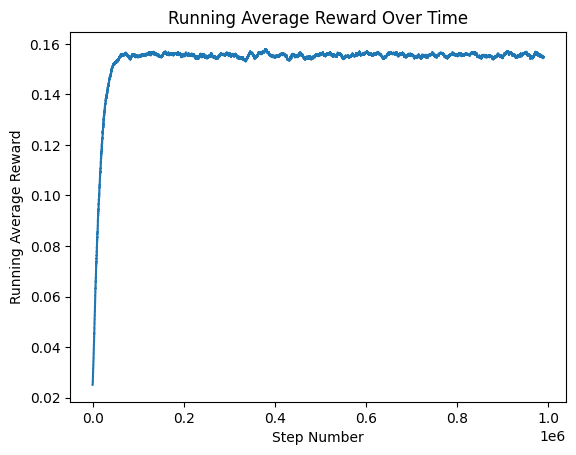

Plotting running average reward for FrozenLake-v1


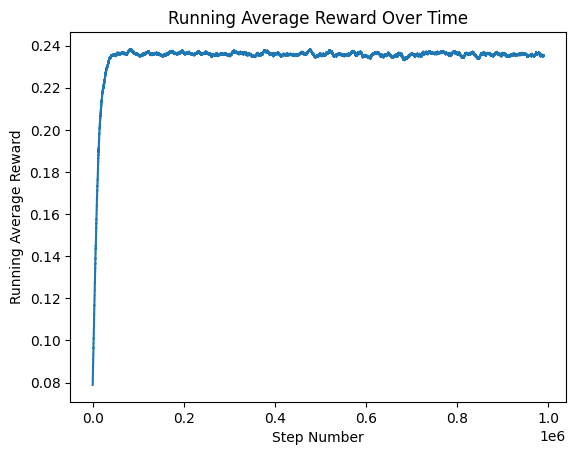

Plotting running average reward for BanditTwoArmedHighLowFixed-v0


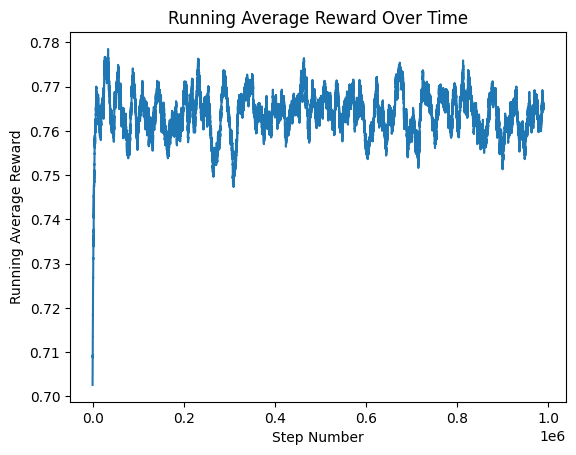

Plotting running average reward for BanditTenArmedRandomFixed-v0


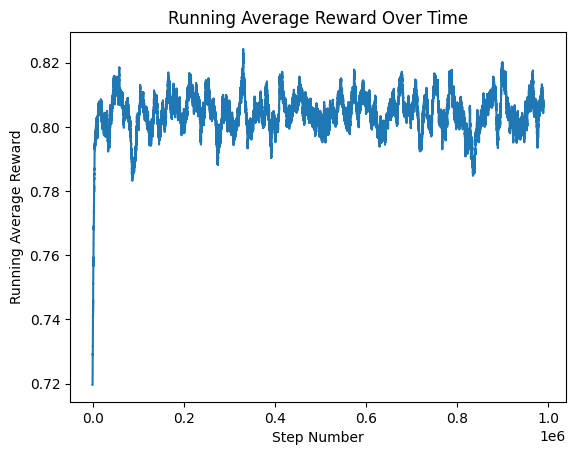

Plotting running average reward for CliffWalking-v0


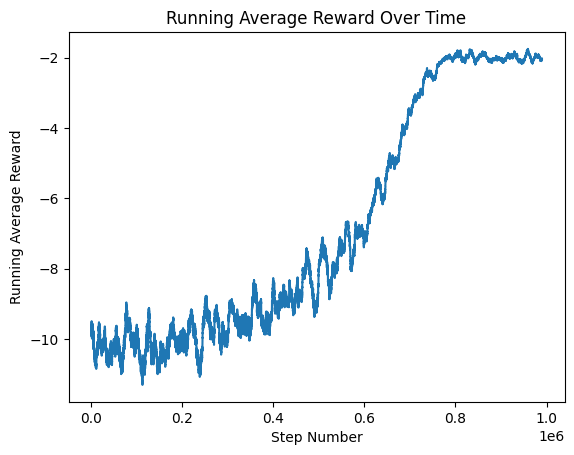

In [76]:
import matplotlib.pyplot as plt

def plot_running_average(rewards, window_size=10000):
    running_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(running_avg)
    plt.title('Running Average Reward Over Time')
    plt.xlabel('Step Number')
    plt.ylabel('Running Average Reward')
    plt.show()

# Assuming `rewards` is a list of rewards from each episode
for env in environment_results:
    rewards = env["metrics"]["rewards"]
    print(f"Plotting running average reward for {env['env_id']}")
    plot_running_average(rewards)